In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np


In [2]:
KERNELS = (
    "gaussian", "tophat", "cosine"
)

BAND_WIDTHS = (
    0.1, 0.5, 1.0, 1.5, 2
)


In [3]:
def get_data(n: int = 200) -> np.array:
    data = []

    for _ in range(n):
        choice = np.random.randint(0, 11)
        if choice < 9:
            data.append(np.random.normal(5, 1))
        else:
            data.append(np.random.normal(10, 1))

    return np.array(data).reshape(-1, 1)


def mse(data: np.array, density_func, estimate_density_func) -> float:
    return np.mean(
        [(density_func(x) - estimate_density_func(x))**2 for x in data]
        )


def f(x: float) -> float:
    return 0.9*norm.pdf(x, 5, 1) + 0.1*norm.pdf(x, 10, 1)


### Draw density function corresponding to theoretical distribution and estimated function

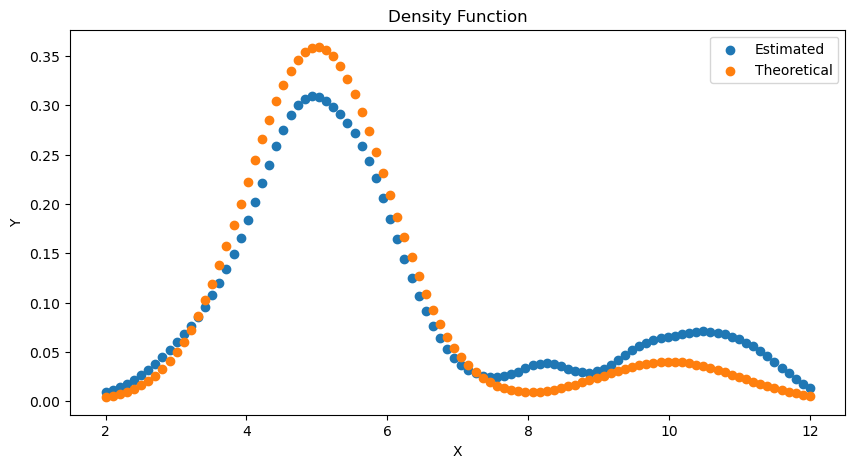

In [4]:
train_data = get_data(n=200)

test_data = np.linspace(2, 12, 100).reshape(-1, 1)

kde = KernelDensity(kernel="gaussian", bandwidth="silverman").fit(train_data)
preds = np.exp(kde.score_samples(test_data))

plt.figure(figsize=(10, 5))
plt.scatter(test_data, preds, label="Estimated")
plt.scatter(test_data, [f(x) for x in test_data], label="Theoretical")
plt.title("Density Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


### Analyse how the error depends on sample size n

0.001479280013524422
0.0009177252724377125
0.0009337589872226361
0.0008256303206256406
0.0007819762121382705
0.0007522885448388557
0.0006758681862371839
0.0006865409000459061
0.0005961563022985957
0.0006265260570443066
0.0006242127877156502
0.000603911278274319
0.0005881699515107773
0.0005864851265500131
0.0005710233129895764
0.0005666920744178227
0.0005597435343052633
0.000576948992443739
0.0005536835050029759


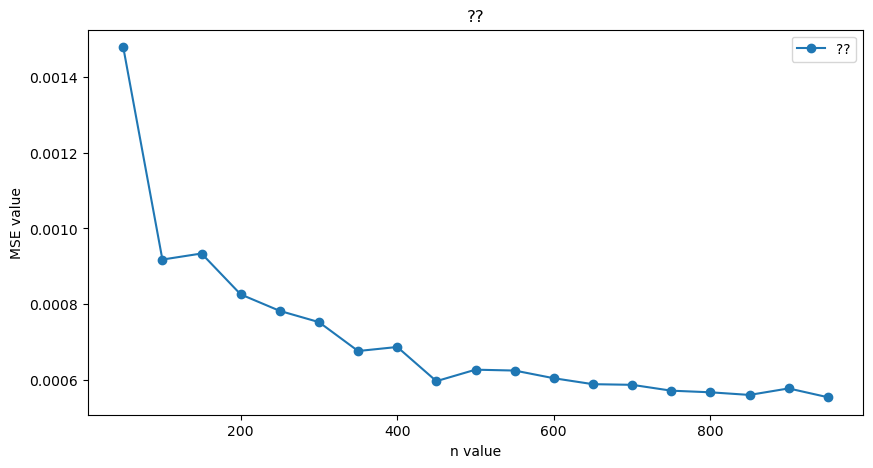

In [13]:
test_data = np.linspace(2, 12, 100).reshape(-1, 1)
real_values = np.array([f(x) for x in test_data]).reshape(1, -1)[0]

n_values = []
mse_values = []

HOW_MANY = 100
for n in range(50, 1000, 50):
    mse_tmp = 0
    for i in range(HOW_MANY):
        train_data = get_data(n=n)

        kde = KernelDensity(kernel="gaussian", bandwidth="silverman").fit(train_data)
        preds = np.exp(kde.score_samples(test_data))

        mse_value = mean_squared_error(preds, real_values)

        mse_tmp += mse_value

    n_values.append(n)
    mse_values.append(mse_tmp/HOW_MANY)


plt.figure(figsize=(10, 5))
plt.plot(n_values, mse_values, "-o", label="??")
plt.title("??")
plt.xlabel("n value")
plt.ylabel("Averange MSE value")
plt.legend()
plt.show()
